<a href="https://colab.research.google.com/github/ErayImamoglu/BERT-Binary/blob/main/BERT_%C4%B0hale_Final_binary_rev00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/train_set_cost_related-_2_.csv")

# Get indices of rows with label 0 and label 1
indices_0 = df[df['CostRelated'] == 0].index
indices_1 = df[df['CostRelated'] == 1].index

# Randomly sample the required number of indices with label 0
random_indices_0 = np.random.choice(indices_0, len(indices_1), replace=False)

# Combine the indices
under_sample_indices = np.concatenate([indices_1, random_indices_0])

# Create the undersampled DataFrame
under_sampled_df = df.loc[under_sample_indices]

# Shuffle the resulting DataFrame for good measure
under_sampled_df = under_sampled_df.sample(frac=1).reset_index(drop=True)

df=under_sampled_df

df['CostRelated'] = df['CostRelated'].astype(int)

# Split the dataset
train_df, eval_df = train_test_split(df, test_size=0.2)

df["CostRelated"].unique()

array([0, 1])

In [ ]:
!pip install accelerate==0.20.1
!pip install datasets transformers==4.28.0

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00


In [ ]:
def preprocess_function(examples):
  return tokenizer(examples, truncation=True)

train_encodings = preprocess_function(train_df["Text"].tolist())
eval_encodings = preprocess_function(eval_df["Text"].tolist())

In [ ]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
from transformers import DataCollatorWithPadding

data_collator=DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
!pip install evaluate
import evaluate

# Compute metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    conf_matrix = confusion_matrix(labels, predictions)
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=["NEGATIVE", "POSITIVE"])
    display.plot(cmap=plt.cm.Blues)
    plt.show()

    return {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': np.mean(predictions == labels)}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.0 MB/s eta 0:00:00


In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [ ]:
# Convert tokenized data into a format compatible with Trainer
class CustomDataset:
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_df["CostRelated"].tolist())
eval_dataset = CustomDataset(eval_encodings, eval_df["CostRelated"].tolist())


In [ ]:
print(train_dataset[5])

{'input_ids': [101, 26226, 2015, 2005, 2490, 3095, 2097, 2025, 2022, 16330, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 0}


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.604132,0.772727,0.918919,0.839506,0.824324
2,No log,0.548850,0.837838,0.837838,0.837838,0.837838


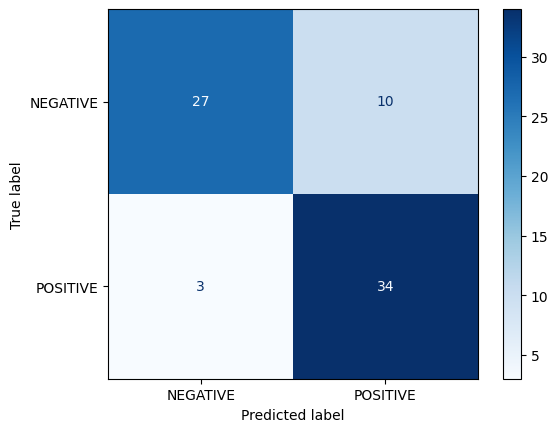

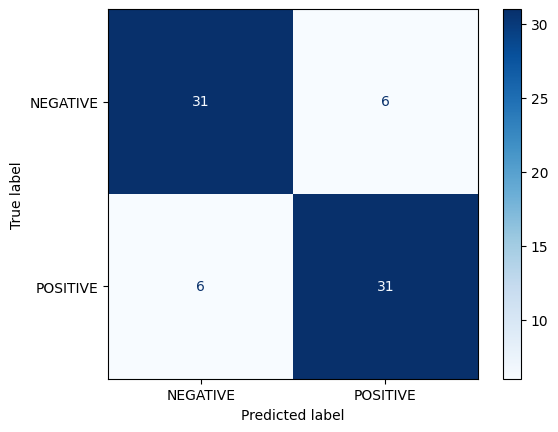

TrainOutput(global_step=38, training_loss=0.626978271885922, metrics={'train_runtime': 305.9459, 'train_samples_per_second': 1.922, 'train_steps_per_second': 0.124, 'total_flos': 12433307245728.0, 'train_loss': 0.626978271885922, 'epoch': 2.0})

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# Trainer instantiation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

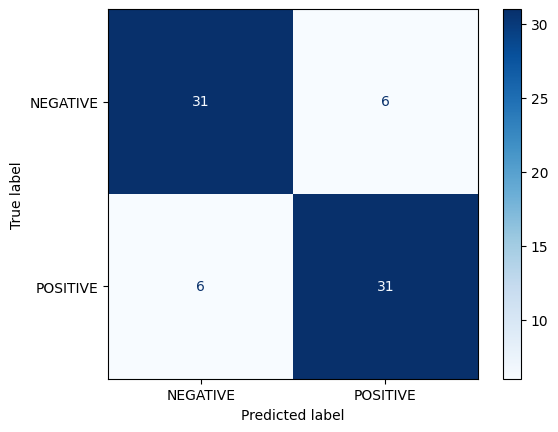

In [ ]:
predictions = trainer.predict(eval_dataset)
logits = predictions.predictions
labels = predictions.label_ids
predicted_labels = np.argmax(logits, axis=1)

In [ ]:
# After training
model_path = "my_awesome_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# Now, use the pipeline
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
result = classifier("The Consultant shall provide vehicles for site transportation for all of his staff, for the entire duration of the Supervision Contract. ")
print(result)

[{'label': 'POSITIVE', 'score': 0.583638072013855}]


In [ ]:
cost_related_sentences = eval_df[predicted_labels == 1]["Text"]

print("Sentences that are cost-related:")
for sentence in cost_related_sentences:
    print(sentence)

Sentences that are cost-related:
The responsibilities delegated to the Consultant will call for the services listed below, without, however, being necessarily and strictly restricted to the items listed
Third Party motor vehicle liability insurance in respect of motor vehicles operated in the Client’s country by the Consultant or its Experts or Sub-consultants, with a minimum coverage in accordance with the applicable law in the Client’s country.
No equipment is to be purchased on behalf of the Contracting Authority / partner country as part of this service contract or transferred to the Contracting Authority / partner country at the end of this contract.
For estimating purposes, a number of individual expert visits and a global number of person-months are to be shown in the proposal and the Consultant should also enter a person-month rate and round-trip air ticket cost.
The Consultant shall be responsible for providing office space and facilities, accommodation and transport for the P

In [ ]:
false_negative_indices = np.where((labels == 1) & (predicted_labels == 0))[0]

false_negative_sentences = eval_df.iloc[false_negative_indices]["Text"]

print("Sentences that are cost-related but were not identified by the model:")
for sentence in false_negative_sentences:
    print(sentence)

Sentences that are cost-related but were not identified by the model:
In order to achieve effective supervision, the proposed sites the consultant shall assign separate teams of experts for each site.
The Consultant shall supply and keep replenished all consumable items.
The provision for expenditure verification covers the fees of the auditor charged with verifying the expenditure of this contract in order to proceed with the payment of any pre-financing instalments and/or interim payments.
Pay taxes and duties payable in accordance with the Laws of the United Republic of Tanzania;
In addition to the above key and non-key specialists the Consultant is encouraged to provide a backstopping pool of expatriate and/or local specialists to cover special needs arising under such disciplines as hydrology, materials, work safety, pavements, structures etc.
The Consultant shall provide adequate security to guard and secure the buildings on a 24 hours per day basis


In [ ]:
# Get a sample sentence from your dataset
sample_sentence = train_df.iloc[0]['Text']

# Print the original sentence
print('Original Sentence: ', sample_sentence)

# Tokenize the sentence
tokenized_sentence = tokenizer.tokenize(sample_sentence)
print('Tokenized Sentence: ', tokenized_sentence)

# Encode the sentence to get input IDs and attention masks. This step adds special tokens and creates attention masks automatically.
encoded_input = tokenizer.encode_plus(sample_sentence, add_special_tokens=True, return_attention_mask=True, padding='max_length', max_length=128, return_tensors='pt')  # I'm using a max length of 128 for this example, adjust as needed.

# Print input IDs and attention masks
print('Input IDs: ', encoded_input['input_ids'])
print('Attention Masks: ', encoded_input['attention_mask'])

Original Sentence:  The Project will be managed on a day-to-day basis by a Project Implementation Unit (“PIU”) which is already established by the Client
Tokenized Sentence:  ['the', 'project', 'will', 'be', 'managed', 'on', 'a', 'day', '-', 'to', '-', 'day', 'basis', 'by', 'a', 'project', 'implementation', 'unit', '(', '“', 'pi', '##u', '”', ')', 'which', 'is', 'already', 'established', 'by', 'the', 'client']
Input IDs:  tensor([[  101,  1996,  2622,  2097,  2022,  3266,  2006,  1037,  2154,  1011,
          2000,  1011,  2154,  3978,  2011,  1037,  2622,  7375,  3131,  1006,
          1523, 14255,  2226,  1524,  1007,  2029,  2003,  2525,  2511,  2011,
          1996,  7396,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0